<a href="https://colab.research.google.com/github/AJStar365/plant_growth_stage/blob/main/EDA_ML_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Growth Stage Classifier: Assignment Notebook

### 1. Notebook Setup and Dependencies

This section covers the initial setup for your Colab environment, including necessary library imports and mounting Google Drive to access your dataset.

In [4]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os

In [5]:
# Mount Google Drive to access the dataset
#from google.colab import drive
#drive.mount('/content/drive')

### 2. Data Preparation

Here, you will define the paths to your dataset stored on Google Drive and set up common image processing parameters like target size and batch size.

Your dataset is expected to be located on your Drive at `My Drive/dataset_resized`, with `train` and `validation` subdirectories. Each of these subdirectories should contain 6 classes of plant images.

In [6]:
# Define paths to your dataset on Google Drive
# IMPORTANT: Adjust this path if your dataset is in a different location
base_data_dir = '/content/drive/My Drive/dataset_resized'
train_dir = os.path.join(base_data_dir, 'train')
val_dir = os.path.join(base_data_dir, 'validation')

# Set image dimensions and batch size
target_size = (224, 224) # InceptionV3 input size
batch_size = 32

### 3. Data Loading with `ImageDataGenerator`

This section sets up `ImageDataGenerator` instances for both training and validation datasets. The generators will handle loading images from disk, resizing them to the `target_size`, and scaling pixel values. For initial diagnosis, we will only apply pixel rescaling and no heavy augmentation.\

In [7]:
# Create ImageDataGenerator for the training set (only rescaling for now)
train_datagen = ImageDataGenerator(rescale=1./255)

# Create ImageDataGenerator for the validation set (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators using flow_from_directory
print("Preparing training data generator...")
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    # shuffle=True for training data
)

print("\nPreparing validation data generator...")
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Keep validation data in order for evaluation
)

# Determine the number of classes from the training generator
num_classes = train_gen.num_classes
print(f"\nDetected {num_classes} classes.")

Preparing training data generator...
Found 269 images belonging to 6 classes.

Preparing validation data generator...
Found 168 images belonging to 6 classes.

Detected 6 classes.


### 4. Model Architecture: InceptionV3 Transfer Learning

Here, we will build our classification model using transfer learning with InceptionV3. The pre-trained InceptionV3 model will serve as a powerful feature extractor, and we will add a custom classification head tailored for our specific plant growth stages.


In [8]:
# Load the InceptionV3 model pre-trained on ImageNet
# include_top=False: don't include the ImageNet classification layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Freeze the layers of the base model
# This prevents their weights from being updated during the initial training phase
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification head on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions
x = Dropout(0.3)(x)             # Regularization to prevent overfitting
predictions = Dense(num_classes, activation='softmax')(x) # Output layer for 6 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,815,078 (83.22 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

### 5. Initial Model Training (Frozen Base)

In this phase, only the newly added classification head will be trained. The weights of the InceptionV3 base model remain frozen. This allows the head to learn how to classify our specific plant stages using the powerful features extracted by the pre-trained base.

In [9]:
# Compile the model for the initial training phase
# Using Adam optimizer with a slightly higher learning rate for the head
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks for initial training
# EarlyStopping: stops training if validation accuracy doesn't improve
# ModelCheckpoint: saves the best model weights based on validation accuracy
callbacks_initial_train = [
    EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint('best_plant_growth_stage_initial.h5', save_best_only=True, monitor='val_accuracy', mode='max')
]

# Train the model
print("\n--- Starting Initial Training (Frozen Base) ---")
history_initial = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20, # Number of epochs for initial training
    callbacks=callbacks_initial_train
)


--- Starting Initial Training (Frozen Base) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2839 - loss: 1.7444

9/9 ━━━━━━━━━━━━━━━━━━━━ 158s 17s/step - accuracy: 0.2946 - loss: 1.7189 - val_accuracy: 0.5833 - val_loss: 1.0713
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7126 - loss: 0.8838

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.7172 - loss: 0.8726 - val_accuracy: 0.8036 - val_loss: 0.6667
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8315 - loss: 0.5882

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.8331 - loss: 0.5783 - val_accuracy: 0.8214 - val_loss: 0.5977
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.9108 - loss: 0.3583 - val_accuracy: 0.7857 - val_loss: 0.5458
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.9241 - loss: 0.2765 - val_accuracy: 0.8214 - val_loss: 0.5370
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.9215 - loss: 0.2081 - val_accuracy: 0.7857 - val_loss: 0.5529
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.9517 - loss: 0.1683 - val_accuracy: 0.7976 - val_loss: 0.5132
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.9563 - loss: 0.1721 - val_accuracy: 0.7857 - val_loss: 0.6037


### 6. Fine-Tuning Phase (Unfrozen Top Layers)

After the initial training, we will unfreeze a portion of the base model's top layers and continue training with a very low learning rate. This allows the model to fine-tune its high-level feature extraction specifically for our dataset, potentially leading to higher accuracy.

In [10]:
# Unfreeze the top layers of the base model (e.g., from layer 249 onwards for InceptionV3)
# This makes them trainable
for layer in base_model.layers[249:]:
    layer.trainable = True

# Re-compile the model with a much lower learning rate for fine-tuning
# This prevents destroying the carefully learned pre-trained weights
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks for fine-tuning
callbacks_finetune = [
    EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint('best_plant_growth_stage_finetuned.h5', save_best_only=True, monitor='val_accuracy', mode='max')
]

# Continue training the model (fine-tuning)
print("\n--- Starting Fine-Tuning (Unfrozen Top Layers) ---")
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15, # Number of additional epochs for fine-tuning
    callbacks=callbacks_finetune
)


--- Starting Fine-Tuning (Unfrozen Top Layers) ---
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7203 - loss: 0.9493

9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.7226 - loss: 0.9460 - val_accuracy: 0.8274 - val_loss: 0.5668
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.8773 - loss: 0.6868 - val_accuracy: 0.8274 - val_loss: 0.5439
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.9354 - loss: 0.5371 - val_accuracy: 0.8274 - val_loss: 0.5387
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9382 - loss: 0.4236

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.9388 - loss: 0.4210 - val_accuracy: 0.8393 - val_loss: 0.5350
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.9598 - loss: 0.3043 - val_accuracy: 0.8274 - val_loss: 0.5367
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.9462 - loss: 0.2748 - val_accuracy: 0.8274 - val_loss: 0.5321
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.9765 - loss: 0.2089 - val_accuracy: 0.8214 - val_loss: 0.5281
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.9653 - loss: 0.1932 - val_accuracy: 0.8214 - val_loss: 0.5268
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.9926 - loss: 0.1741 - val_accuracy: 0.8274 - val_loss: 0.5285
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.9810 - loss: 0.1412 - val_accuracy: 0.8333 - val_loss: 0.5232
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.9824 - loss: 0.1229 - val_accuracy: 0.8333 - val_loss: 0.5215
E

### 7. Model Evaluation and Visualization

This final section covers evaluating the performance of your trained model using a classification report and visualizing the training progress with Matplotlib plots


✅ Final model saved as plant_growth_stage_final.h5

--- Model Evaluation (Classification Report) ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step

Classification Report:
                  precision    recall  f1-score   support

       Flowering       0.82      0.93      0.88        15
   Fruiting_Ripe       0.78      1.00      0.88        29
 Fruiting_Unripe       0.94      0.77      0.84        64
        Seedling       0.92      0.71      0.80        17
Vegetative_Early       0.69      1.00      0.82        25
 Vegetative_Late       0.92      0.67      0.77        18

        accuracy                           0.84       168
       macro avg       0.85      0.85      0.83       168
    weighted avg       0.86      0.84      0.84       168


--- Training History Visualization ---


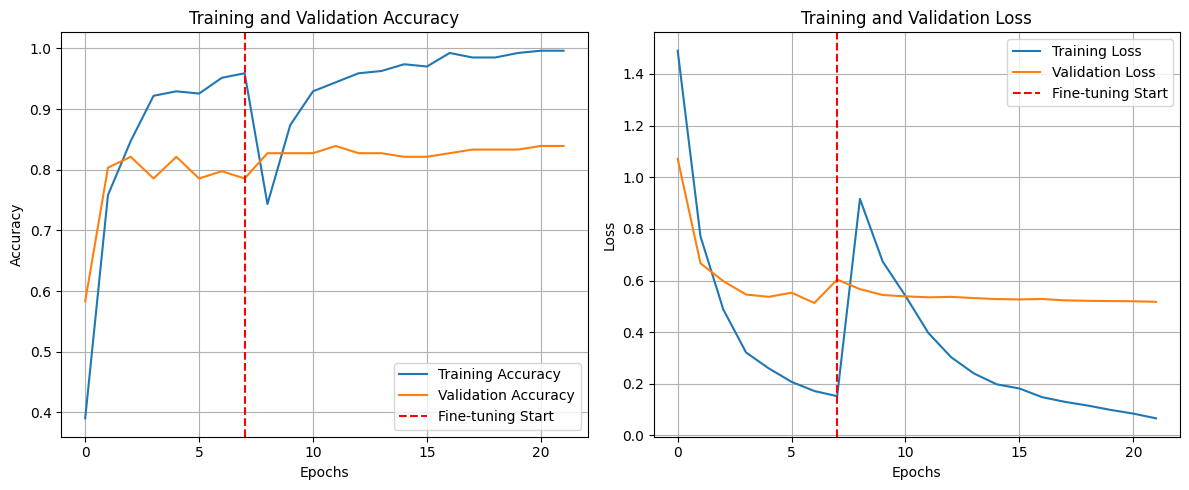

In [11]:
# Save the final trained model
model.save("plant_growth_stage_final.h5")
print("\n✅ Final model saved as plant_growth_stage_final.h5")

# --- Scikit-learn Classification Report ---
print("\n--- Model Evaluation (Classification Report) ---")
# Get predictions on the validation set
val_gen.reset() # Important to reset generator before prediction
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis=1) # Convert probabilities to class labels

# Get true labels
y_true = val_gen.classes

# Get class names
class_names = list(val_gen.class_indices.keys())

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


# --- Matplotlib Training History Visualization ---
print("\n--- Training History Visualization ---")

def plot_training_history(history_initial, history_finetune):
    # Combine history objects for plotting
    acc = history_initial.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history_initial.history['loss'] + history_finetune.history['loss']
    val_loss = history_initial.history['val_loss'] + history_finetune.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history_initial.history['accuracy']) - 1, color='r', linestyle='--', label='Fine-tuning Start')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)


    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=len(history_initial.history['accuracy']) - 1, color='r', linestyle='--', label='Fine-tuning Start')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history_initial, history_finetune)

In [12]:
from google.colab import files

files.download('plant_growth_stage_final.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>